In [160]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import colors
import random

# Integer Program Formulation
This notebook outlines an integer programming perspective on the Covid-19 scheduling problem. In its current iteration, this model schedules people on a week-by-week basis, ensuring that people take $F_i = 2$ tests per week (if feasible, i.e. available at least 2 days) and attempting to keep the number of tests on any given day below a reasonable bound.

The optimized variable is a $assignment$, a $(n\_people, n\_days)$ binary matrix where each row is the weekly schedule for one person, where 0 means 'no test' and 1 means 'test'. We can incorporate $avail$, which is a $(n\_people, n\_days)$ binary matrix that marks on which days people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and summing across rows gives a $ n\_people $ vector with the counts of well-scheduled tests that week for each person. Moreover, summing $ assignment$ across columns gives the total number of tests per day, which we want to keep fairly even.

# setup

One important aspect is creating a realistic schedule on which to test our model. It's not as simple as just letting everyone have random availability. It would be nice to have a tool that allows you to tweak the specific scheduling parameters for different campuses. Here are things we should consider:
* Split campus community members into three groups — students, faculty, staff
* A large proportion of students should be available 7 days a week, since they live on campus
* The rest of the students should be available on the weekends and either on MWF or TTh (this is at least the case at UChicago — should investigate more)
* Professors should be available 1-2 days a week, never on weekends
  * If 2 days a week, not consecutive days?
* Staff ??? depends on the staff, need to think more about this.

In [162]:
def make_avails(student_pct, prof_pct, staff_pct):
    sum = student_pct + prof_pct + staff_pct
#     print("Sum of percents is %.02f (should be 1.00)" % sum)
    
    weeks = {'fully_avail':[1,1,1,1,1,1,1], 'mwf':[1,0,1,0,1,1,1], 'tth':[0,1,0,1,0,1,1],
             '1prof1':[1,0,0,0,0,0,0], '1prof2':[0,1,0,0,0,0,0], '1prof3':[0,0,1,0,0,0,0],
             '1prof4':[0,0,0,1,0,0,0], '1prof5':[0,0,0,0,1,0,0], '1prof1':[1,0,0,0,0,0,0],
             '2prof1':[1,0,1,0,0,0,0], '2prof2':[0,1,0,1,0,0,0], '2prof3':[0,0,1,0,1,0,0]}

    
    avail = np.zeros((n_people, n_days))
    for row in range(len(avail)):
        member = random.uniform(0,1)
        if member < student_pct: 
            studentAvail = random.uniform(0,1)
            if studentAvail < 0.7:
                avail[row] = weeks['fully_avail']
                continue
            else:
                flipCoin = random.uniform(0,1)
                if flipCoin < 0.5:
                    avail[row] = weeks['mwf']
                    continue
                else:
                    avail[row] = weeks['tth']
                    continue
        elif member < student_pct + prof_pct + staff_pct: # treat staff same as profs (for now)
            oneOrTwo = random.uniform(0,1)
            if oneOrTwo < 0.7: # 70% chance profs/staff are one campus 1x a week
                i = '1'
                day = str(random.randint(1,5))
                avail[row] = weeks[i + 'prof' + day]
                continue
            else:
                i = '2'
                day = str(random.randint(1,3))
                avail[row] = weeks[i + 'prof' + day]
                continue
    return avail

In [169]:
def runSetup(pcts):
    # create random availability matrix
#     avail = np.random.randint(0,2, size=(n_people, n_days)) # truly random
    avail = make_avails(pcts[0], pcts[1], pcts[2]) # more realistic
    
    # Identify people who have infeasible availabilities
    people_total_availability = np.sum(avail, 1)
    infeasible_people = np.where(people_total_availability < n_tests)
    
    # If people have 2 or fewer available days, their schedule can't be shifted
    # to account for optimal spacing
    unshiftable_people = np.where(people_total_availability <= n_tests)

    # beq tracks how many tests people should take — 2 if possible, fewer if they're less available
    beq = np.multiply(n_tests, np.ones((n_people,1)))
    for i in range(len(infeasible_people[0])):
        beq[infeasible_people[0][i]][0] = people_total_availability[infeasible_people[0][i]]
        
    # Setup for the optimal spacing constraint — see optimization constraints below
    spaces = np.ones((n_people,))
    for i in range(len(unshiftable_people[0])):
        spaces[unshiftable_people[0][i]] += 1 

    # Calculate the average number of tests per day
    b_value = (n_people*n_tests/n_days)
    b = np.multiply(b_value, np.ones((n_days,1)))
    
    return avail, b, beq, spaces

# cvxpy optimization

In [177]:
n_days = 7
n_people = 1000
test_interval = 3.5 # corresponds to Qs_i
n_tests = n_days / test_interval # corresponds to F_i
buffer = .25

avail, b, beq, spaces = runSetup([.7,.2,.1])

def runOpt():
    assignment = cp.Variable((n_people, n_days), boolean=True)

    # Working on an objective function to track schedule spacing
    # (not working right now, not implemented)
    def objective():
        expr = []
        for i in range(n_days):
            for j in range(i + 1, n_days):
                penalty = ((j - i) - test_interval)**2
                expr.append(penalty * cp.sum(assignment[:, i], assignment[:, j]))
        expr.append(cp.sum(expr))
        
    # Helper matrix to identify consecutive tests
    adjacencies = np.zeros((n_days-1, n_days))
    for i in range(n_days-1):
        adjacencies[i][i] = 1
        adjacencies[i][i+1] = 1

    constraints = [
        cp.sum(assignment, axis=0) <= np.ceil(b.transpose()[0] * (1 + buffer)), # set load upper bound
        cp.sum(assignment, axis=0) >= np.floor(b.transpose()[0] * (1 - buffer)), # set load lower bound
        cp.sum(assignment, axis=1) == beq.transpose()[0], # enforce taking F_i tests
        cp.sum(cp.multiply(assignment, avail), axis=1) == beq.transpose()[0] # align with availability
    ]
    
    # Ensure each person has no consecutive days scheduled, unless that's all they can do
    for i in range(6):
        consec = adjacencies[i]*np.ones((n_people,1))
        constraints.append(cp.sum(cp.multiply(assignment, consec), axis=1) <= spaces)

#     obj = cp.Minimize(objective()) # Spread objective function (not working)
    obj = cp.Maximize(cp.sum(assignment)) # Dummy objective function

    prob = cp.Problem(obj, constraints=constraints)
    prob.solve()

    return assignment

def analyze(assignment):
    # Compute spread score (lower is better)
    score = 0
    for week in assignment.value:
        scheduled_days = []
        for i in range(n_days):
            if week[i] == 1:
                scheduled_days.append(i)
        if len(scheduled_days) == 2:
            score += ((scheduled_days[1] - scheduled_days[0]) - test_interval) ** 2
    spreadScore = score / n_people
    
    # Compute daily demands, deviations
    daily_demands = np.sum(assignment.value, axis=0)
    exp_supply_per_day = n_people * n_tests / n_days
    max_deviation = max(daily_demands.max() - exp_supply_per_day,
                        exp_supply_per_day - daily_demands.min()) / exp_supply_per_day # MIN, right?
    
    return spreadScore, daily_demands, max_deviation

assignment = runOpt()

if assignment.value is not None:
    spreadScore, daily_demands, max_deviation = analyze(assignment)
    print("Optimization done")
else:
    print("Situation infeasible")

Optimization done


# analysis

In [178]:
print("Spread score is: %.02f" % spreadScore)
print("Max deviation %% is: %.01f" % (100 * max_deviation))
print('Daily demand (min):', daily_demands.min())
print('Daily demand (max):', daily_demands.max())
print('All daily demands:', daily_demands)


if n_people < 1000:
    # Display Calendar
    scaled_assignment = np.multiply(assignment.value, 0.5)
    data = np.add(scaled_assignment, avail)

    outputColors = colors.ListedColormap(['gray', 'red', 'yellow', 'green'])
    availColors = colors.ListedColormap(['gray', 'yellow'])

    plt.figure(num=1, figsize=(8,n_people/5))
    plt.title("Output Vector", fontsize=16)
    plt.imshow(data, cmap=outputColors, aspect='auto', extent=[0, n_days, n_people, 0])
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)
    plt.xticks(np.arange(0,n_days, 1))
    plt.yticks(np.arange(0, n_people, 1))

    plt.xlabel("Day", fontsize=12)
    plt.ylabel("Person", fontsize=12)
    plt.savefig('output.png', dpi=300, bbox_inches='tight')
    plt.show()

Spread score is: 1.40
Max deviation % is: 25.1
Daily demand (min): 214.0
Daily demand (max): 309.0
All daily demands: [309. 239. 274. 263. 241. 214. 252.]


# running many trials
to check the distributions of spread scores, load balancing deviations

In [149]:
%%time

spreads = []
devs = []
infeasible = 0
for t in range(1000):
    if (t%100 == 0):
        print(t)
    avail, b, beq, spaces = runSetup()
    assignment = runOpt()
    if assignment.value is not None:
        spreadScore, daily_demands, max_deviation = analyze(assignment)
        spreads.append(spreadScore)
        devs.append(100 * max_deviation)
    else:
        infeasible += 1
print("There were %d infeasible situations" % infeasible)

0
100
200
300
400
500
600
700
800
900
There were 0 infeasible situations
CPU times: user 4min 30s, sys: 5.98 s, total: 4min 36s
Wall time: 4min 37s


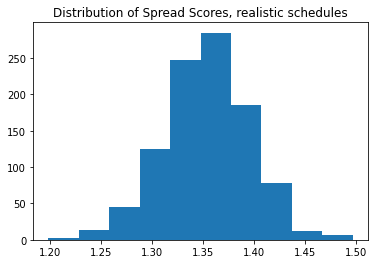

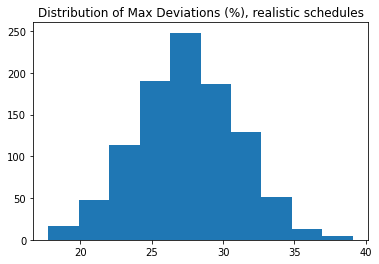

In [150]:
plt.title("Distribution of Spread Scores, realistic schedules")
plt.hist(spreads)
plt.savefig('spreads_realistic_bounded.png', dpi=300, bbox_inches='tight')
plt.show()

plt.title("Distribution of Max Deviations (%), realistic schedules")
plt.hist(devs)
plt.savefig('maxDevs_realistic_bounded.png', dpi=300, bbox_inches='tight')
plt.show()